In [1]:
import csv 
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from swarm_sim import *

%matplotlib inline 

## Load the data and format it as Swarm object

In [2]:
PATH = '..\data\Traces_Nanosatellites\\track_'
satellites = {}

with tqdm(total=100, desc='Extracting data') as pbar:
    for i in range(0,100):
        df = pd.read_csv(PATH+str(i)+'.csv', sep=',', header=0)
        df['coords'] = ['x','y','z']
        satellites[i] = df.set_index('coords', drop=True)
        pbar.update(1)
    
DURATION = satellites[0].columns.tolist()
CHUNKS = 1800     # Number of timestamps to analyse
NB_NODES = 100

satellites[0].head()

Extracting data: 100%|██████████| 100/100 [02:17<00:00,  1.38s/it]


,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
coords,,,,,,,,,,,,,,,,,,,,,
x,-4.850747e+05,-4.937755e+05,-5.024536e+05,-5.111086e+05,-5.197401e+05,-5.283476e+05,-5.369309e+05,-5.454894e+05,-5.540229e+05,-5.625310e+05,...,1.490967e+06,1.494274e+06,1.497573e+06,1.500865e+06,1.504149e+06,1.507425e+06,1.510693e+06,1.513954e+06,1.517206e+06,1.520451e+06
y,-7.066530e+05,-7.201117e+05,-7.335372e+05,-7.469290e+05,-7.602864e+05,-7.736088e+05,-7.868957e+05,-8.001464e+05,-8.133603e+05,-8.265368e+05,...,2.218138e+06,2.223313e+06,2.228477e+06,2.233629e+06,2.238769e+06,2.243898e+06,2.249015e+06,2.254120e+06,2.259214e+06,2.264296e+06
z,-2.026363e+06,-2.019625e+06,-2.012795e+06,-2.005871e+06,-1.998855e+06,-1.991747e+06,-1.984548e+06,-1.977257e+06,-1.969876e+06,-1.962403e+06,...,3.692429e+06,3.686602e+06,3.680756e+06,3.674890e+06,3.669006e+06,3.663103e+06,3.657180e+06,3.651239e+06,3.645278e+06,3.639299e+06


In [9]:
CONNECTION_RANGE = 30000
swarm_data = {}

with tqdm(total = len(DURATION), desc = 'Converting to Swarm') as pbar:
    for t in DURATION:
        swarm_data[int(t)] = Swarm(
            connection_range=CONNECTION_RANGE, 
            nodes=[Node(id, node[str(t)].x, node[str(t)].y, node[str(t)].z) for id,node in satellites.items()]
            )
        pbar.update(1)

print(swarm_data[0])

Converting to Swarm: 100%|██████████| 10000/10000 [01:06<00:00, 150.22it/s]

Swarm of 100 node(s), connection range: 30000


In [10]:
with tqdm(total=len(swarm_data.keys()), desc='Neighbor matrix') as pbar:
    for t in swarm_data.keys():
        neighbor_matrix = swarm_data[t].neighbor_matrix()
        pbar.update(1)

Neighbor matrix: 100%|██████████| 10000/10000 [01:23<00:00, 120.17it/s]


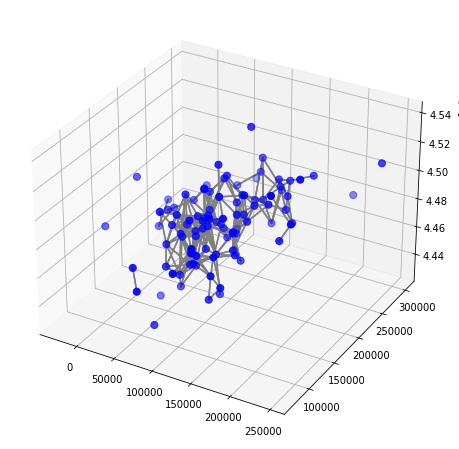

In [11]:
swarm_data[700].plot_edges()

### Compute node degree distribution & evolution over the whole duration (optional)

In [12]:
degree_distrib = {}

with tqdm(total=len(swarm_data.keys()), desc='Degree distribution') as pbar:
    for t,swarm in swarm_data.items():
        degree_distrib[t] = swarm.degree()
        pbar.update(1)           

Degree distribution: 100%|██████████| 10000/10000 [00:00<00:00, 21923.74it/s]


In [13]:
dmin = [np.min(d) for d in degree_distrib.values()]
#dq1 = [np.quantile(d, 0.25) for d in degree_distrib.values()]
dmed = [np.median(d) for d in degree_distrib.values()]
#dq3 = [np.quantile(d, 0.75) for d in degree_distrib.values()]
dmax = [np.max(d) for d in degree_distrib.values()]

In [22]:
dmean = [np.mean(d) for d in degree_distrib.values()]

Text(0, 0.5, 'Degree')

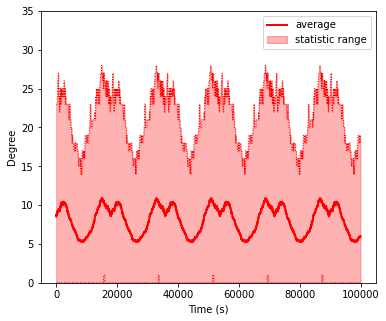

In [23]:
idx = np.arange(0,100000,10)

plt.figure(figsize=(6,5))
plt.plot(idx, dmax, c='red', lw=1, ls=':')
plt.plot(idx, dmean, label='average', c='red', lw=2)
plt.plot(idx, dmin, c='red', lw=1, ls=':')
plt.fill_between(x=idx, y1=dmin, y2=dmax, color='red', alpha=0.3, label='statistic range')
#plt.plot(idx, dq1, label='Q1', c='blue', lw=1)
#plt.plot(idx, dq3, label='Q3', c='red', lw=1)
plt.ylim(0,35)
plt.legend(loc='upper right')
plt.xlabel('Time (s)')
plt.ylabel('Degree')

In [31]:
print('Highest connection:', dmin.index(np.max(dmin)))
print('Lowest connection:', dmax.index(np.min(dmax)))
print('Average connection:', dmean.index(np.floor(np.mean(dmean))))

Highest connection: 1556
Lowest connection: 810
Average connection: 484


In [32]:
degree_range = {
    810: degree_distrib[810],
    484: degree_distrib[484],
    1556: degree_distrib[1556]
}

Text(0.5, 0, 'Node degree')

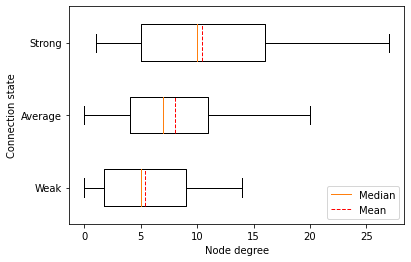

In [34]:
fig,ax = plt.subplots(figsize=(6,4))

bp = ax.boxplot(degree_range.values(), 
            vert=False, 
            widths=0.5,
            meanline=True, 
            showmeans=True, 
            meanprops={'color':'red','ls':'--'}
            )
ax.legend([bp['medians'][0], bp['means'][0]], ['Median', 'Mean'])
ax.set_yticklabels(['Weak','Average','Strong']) #degree_range.keys()
ax.set_ylabel('Connection state')
ax.set_xlabel('Node degree')

#fig.suptitle('Node degree distribution')

## Neighbor discovery on smaller chunk of data

In [13]:
def compute_neighbor_matrix(swarm_chunk, connection_range=None):
    neighbor_matrix = {}
    with tqdm(total=CHUNKS, desc='Computing Neighbor matrix') as pbar:
        for t,swarm in swarm_chunk.items():
            neighbor_matrix[t] = swarm.neighbor_matrix(connection_range)
            pbar.update(1)
    return neighbor_matrix

def compute_swarm_degree(swarm_chunk):
    swarm_degree = {}
    with tqdm(total=CHUNKS, desc='Computing Swarm degree') as pbar:    
        for t,swarm in swarm_chunk.items():
            swarm_degree[t] = swarm.degree()
            pbar.update(1)
    return swarm_degree

def init_network(swarm_chunk, cr=None):
    if not cr:
        cr = swarm_chunk[0].connection_range
    print('\nConnection range:', cr)
    neighbor_matrix = compute_neighbor_matrix(swarm_chunk, connection_range=cr)
    swarm_degree = compute_swarm_degree(swarm_chunk)
    sum_data = [e for t in swarm_degree.keys() for e in swarm_degree[t]]
    print('Minimum number of neighbors:', np.min(sum_data))
    print('Maximum number of neighbors:', np.max(sum_data))
    print('Average number of neighbors:', np.mean(sum_data))
    node_ict = []
    for i in range(NB_NODES):
        node_data = [swarm_degree[t][i] for t in swarm_degree.keys()]
        node_ict.append(node_data.count(0) / float(CHUNKS)*100)
    mean_ict = np.mean(node_ict)
    print('Mean inter-contact time:', mean_ict)

def compute_swarm_kvicinity(swarm_chunk, depth=1):
    swarm_kv = {}
    with tqdm(total=CHUNKS, desc=f'Computing Swarm k-vicinity (depth {depth})') as pbar:    
        for t,swarm in swarm_chunk.items():
            swarm_kv[t] = swarm.k_vicinity(depth)
            pbar.update(1)
    return swarm_kv

def avg_kvicinity(swarm_chunk, depth=1):
    swarm_kv = compute_swarm_kvicinity(swarm_chunk, depth)
    avg_kv = {}
    for i in range(NB_NODES):
        avg_kv[i] = np.mean([swarm_kv[t][i] for t in swarm_kv.keys()])
    return avg_kv
            

In [15]:
init_network(swarm_chunk, cr=40000)


Connection range: 40000


Computing Swarm degree: 100%|██████████| 2000/2000 [00:00<00:00, 26604.74it/s]


Minimum number of neighbors: 0
Maximum number of neighbors: 43
Average number of neighbors: 16.07877
Mean inter-contact time: 3.6914999999999996


In [35]:
swarm_chunk = {}
for t in range(484, 484+1800, 1):
    swarm_chunk[t] = swarm_data[t]
    
print(swarm_chunk[484])

Swarm of 100 node(s), connection range: 30000


In [36]:
def compute_swarm_kvicinity(swarm_chunk, depth=1):
    swarm_kv = {}
    with tqdm(total=len(swarm_chunk.keys()), desc=f'Computing k-vicinity (depth {depth})') as pbar:    
        for t,swarm in swarm_chunk.items():
            swarm_kv[t] = swarm.k_vicinity(depth)
            pbar.update(1)
    return swarm_kv

def avg_kvicinity(swarm_chunk, depth=1):
    swarm_kv = compute_swarm_kvicinity(swarm_chunk, depth)
    avg_kv = {}
    for i in range(NB_NODES):
        avg_kv[i] = np.mean([swarm_kv[t][i] for t in swarm_kv.keys()])
    return avg_kv

In [37]:
k_vicinities= {}
for i in range(1,4):
    k_vicinities[i] = avg_kvicinity(swarm_chunk, depth=i)

Computing k-vicinity (depth 3): 100%|██████████| 1800/1800 [00:16<00:00, 107.77it/s]


Text(0, 0.5, 'K-vicinity')

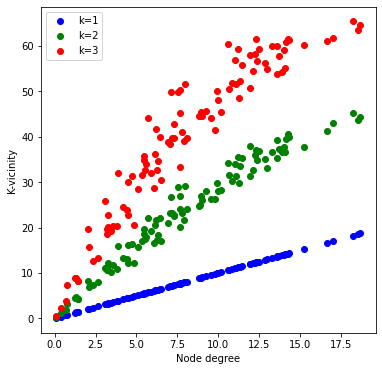

In [38]:
plt.figure(figsize=(6,6))
idx = list(k_vicinities[1].values()) # Degree
colors = {1:'blue',2:'green',3:'red'}
for k,v in k_vicinities.items():
    plt.scatter(idx, list(v.values()), c=colors[k], lw=1, label='k='+str(k))
plt.legend(loc='upper left')
plt.xlabel('Node degree')
plt.ylabel('K-vicinity')
#plt.title('Evolution of k-vicinity in function of node degree')

# Network characterization

## 1. Intercontact time and disponibility

In [39]:
def compute_neighbor_matrix(swarm_chunk, connection_range=None):
    neighbor_matrix = {}
    with tqdm(total=len(swarm_chunk.keys()), desc='Computing Neighbor matrix') as pbar:
        for t,swarm in swarm_chunk.items():
            neighbor_matrix[t] = swarm.neighbor_matrix(connection_range)
            pbar.update(1)
    return neighbor_matrix

def pairwise_dispo(neighbor_matrix):
    dispos = {} # (n1,n2):avg_dispo (%)
    for n1 in range(NB_NODES):
        pairs = [set(pair) for pair in dispos.keys()]
        for n2 in range(NB_NODES):
            if n1 != n2 and set([n1,n2]) not in pairs:
                pair_dispo = [neighbor_matrix[t][n1][n2] for t in neighbor_matrix.keys()]
                dispos[(n1,n2)] = np.mean(pair_dispo)*100
    return dispos    

def pairwise_ict(neighbor_matrix):
    ict = {} # (n1,n2):avg_ict (%)
    for n1 in range(NB_NODES):
        pairs = [set(pair) for pair in ict.keys()]
        for n2 in range(NB_NODES):
            if n1 != n2 and set([n1,n2]) not in pairs:
                pair_ict = [neighbor_matrix[t][n1][n2] for t in neighbor_matrix.keys()]
                ict[(n1,n2)] = (1-np.mean(pair_ict))*100
    return ict    
            

In [40]:
matrix = compute_neighbor_matrix(swarm_chunk)

Computing Neighbor matrix: 100%|██████████| 1800/1800 [00:18<00:00, 96.08it/s] 


Text(0, 0.5, 'Disponibility (%)')

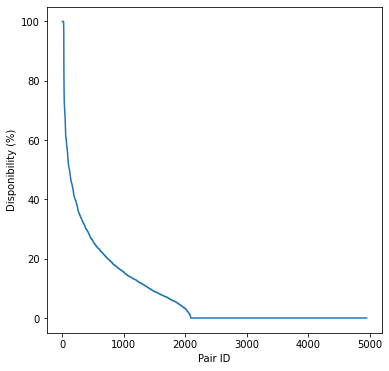

In [41]:
dispos = pairwise_dispo(matrix)
pair_dispo = sorted(dispos.values(), reverse=True)
cr = CONNECTION_RANGE/1000

plt.figure(figsize=(6,6))
plt.plot(pair_dispo)
plt.xlabel('Pair ID')
plt.ylabel('Disponibility (%)')
#plt.title(f'Average disponibility for each pair of nodes (range={cr} km)')

In [42]:
ict = pairwise_ict(matrix)

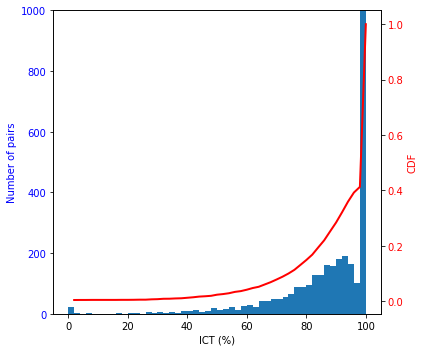

In [50]:
cr = CONNECTION_RANGE/1000
count, bins_count = np.histogram(list(ict.values()), bins=50)
pdf = count / sum(count)
cdf = np.cumsum(pdf)

fig, ax1 = plt.subplots(figsize=(6,5))

ax1.hist(ict.values(), bins=50)
ax1.set_ylabel('Number of pairs', color='blue')
ax1.set_xlabel('ICT (%)')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0,1000)

ax2 = ax1.twinx()
ax2.plot(bins_count[1:], cdf, color='red', lw=2)
ax2.set_ylabel('CDF', color='red')
ax2.tick_params(axis='y', labelcolor='red')

#fig.suptitle(f'Average ICT distribution for each pair of nodes (range={cr} km)')
fig.tight_layout()

## 1.2 Graph Density

In [51]:
graph_density = [swarm.graph_density() for swarm in swarm_chunk.values()]

Text(0, 0.5, 'Graph density')

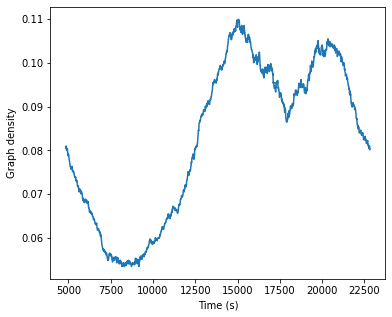

In [57]:
plt.figure(figsize=(6,5))
idx = [e*10 for e in list(swarm_chunk.keys())]
plt.plot(idx, graph_density)
plt.xlabel('Time (s)')
plt.ylabel('Graph density')

## 1.3 Connected components

In [59]:
nb_cc = [len(sw.connected_components()) for sw in swarm_chunk.values()]

Text(0, 0.5, 'Number of connected components')

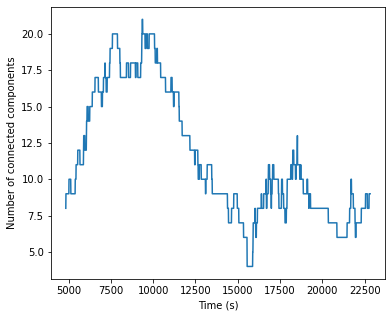

In [60]:
plt.figure(figsize=(6,5))
idx = [e*10 for e in list(swarm_chunk.keys())]
plt.plot(idx, nb_cc)
plt.xlabel('Time (s)')
plt.ylabel('Number of connected components')

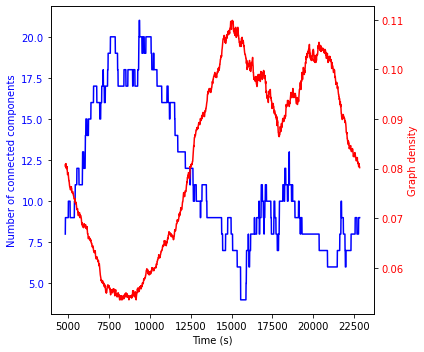

In [61]:
fig, ax1 = plt.subplots(figsize=(6,5))
idx = [e*10 for e in list(swarm_chunk.keys())]

ax1.plot(idx, nb_cc, c='blue')
ax1.set_ylabel('Number of connected components', color='blue')
ax1.set_xlabel('Time (s)')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(idx, graph_density, c='red')
ax2.set_ylabel('Graph density', color='red')
ax2.tick_params(axis='y', labelcolor='red')

#fig.suptitle(f'Average ICT distribution for each pair of nodes (range={cr} km)')
fig.tight_layout()

## 2. Peer-to-peer distances

In [13]:
def compute_distance_matrix(swarm_chunk):
    distance_matrix = {}
    with tqdm(total=CHUNKS, desc='Computing Distance matrix') as pbar:
        for t,swarm in swarm_chunk.items():
            distance_matrix[t] = swarm.distance_matrix()
            pbar.update(1)
    return distance_matrix


In [14]:
dm = compute_distance_matrix(swarm_chunk)

Computing Distance matrix: 100%|██████████| 2000/2000 [00:11<00:00, 173.42it/s]


In [24]:
distance_data = [e for data in dm.values() for node in data for e in node]

Text(0.5, 1.0, 'Peer-to-peer distance distribution')

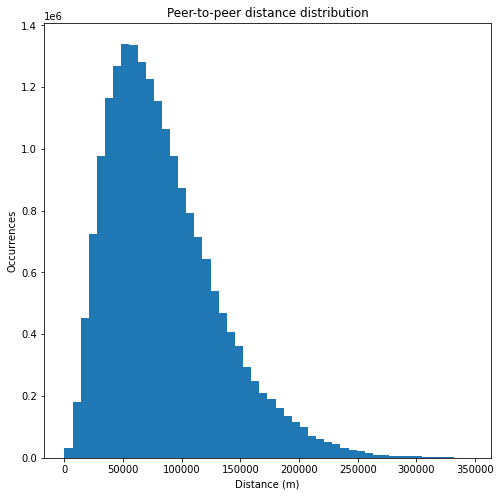

In [29]:
plt.figure(figsize=(8,8))
plt.hist(distance_data, bins=50)
plt.xlabel('Distance (m)')
plt.ylabel('Occurrences')
plt.title(f'Peer-to-peer distance distribution')


Text(0.5, 0.98, 'Peer-to-peer distance distribution')

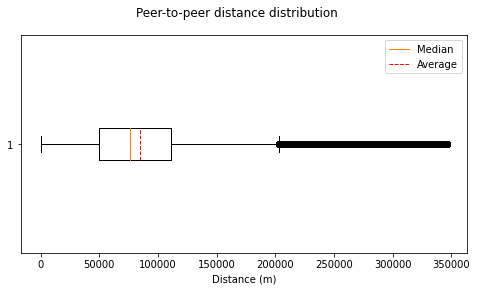

In [28]:
fig,ax = plt.subplots(figsize=(8,4))

bp = ax.boxplot(distance_data, 
            vert=False, 
            meanline=True, 
            showmeans=True, 
            meanprops={'color':'red','ls':'--'}
            )
ax.legend([bp['medians'][0], bp['means'][0]], ['Median', 'Average'])
ax.set_xlabel('Distance (m)')

fig.suptitle('Peer-to-peer distance distribution')

## Clustering coefficient distribution

In [ ]:
# http://mlg.eng.cam.ac.uk/pub/pdf/HueBorKriGha08.pdf
"""
Graph mining for finding representative subgraphs
Interesting metrics for Metropolis algorithm for sampling and evaluating:
    x graph degree distribution d_avg, d(v)
    x clustering coefficient Cv of node v with degree d(v): number of edges actually existing between neighbors of v
      divided by the maximum possible number of such edges between its neighbors d(v)*(d(v)-1)/2
    x clustering coefficient distribution Cd = avg(Cv)
    - graphlet distribution: given a graph G, a k-graphlet is a connected and induced subgraph of G of size k.
      Use the distribution of 3,4 and 5-graphlets in the graph.
For evaluation purpose only:
    - diameter of the graph: maximum shortest path length between any pair of nodes in the graph
"""

In [3]:
t = '0'
swarm_20 = Swarm(
    connection_range=20000, 
    nodes=[Node(id, node[t].x, node[t].y, node[t].z) for id,node in satellites.items()]
    )
print(swarm_20)

nm20 = swarm_20.neighbor_matrix()
d20 = swarm_20.degree()
print('Average node degree:', np.mean(d20))

cc20 = swarm_20.cluster_coef()
print('Average clustering coefficient:', np.mean(cc20))

Swarm of 100 node(s), connection range: 20000
Average node degree: 3.48
Average clustering coefficient: 0.34571645021645026


In [3]:
t = '0'
swarm_30 = Swarm(
    connection_range=30000, 
    nodes=[Node(id, node[t].x, node[t].y, node[t].z) for id,node in satellites.items()]
    )
print(swarm_30)

nm30 = swarm_30.neighbor_matrix()
d30 = swarm_30.degree()
print('Average node degree:', np.mean(d30))

cc30 = swarm_30.cluster_coef()
print('Average clustering coefficient:', np.mean(cc30))

Swarm of 100 node(s), connection range: 30000
Average node degree: 8.54
Average clustering coefficient: 0.47772946676870487


In [5]:
t = '0'
swarm_40 = Swarm(
    connection_range=40000, 
    nodes=[Node(id, node[t].x, node[t].y, node[t].z) for id,node in satellites.items()]
    )
print(swarm_40)

nm40 = swarm_40.neighbor_matrix()
d40 = swarm_40.degree()
print('Average node degree:', np.mean(d40))

cc40 = swarm_40.cluster_coef()
print('Average clustering coefficient:', np.mean(cc40))

Swarm of 100 node(s), connection range: 40000
Average node degree: 17.66
Average clustering coefficient: 0.6330080705128819


In [6]:
t = '0'
swarm_50 = Swarm(
    connection_range=50000, 
    nodes=[Node(id, node[t].x, node[t].y, node[t].z) for id,node in satellites.items()]
    )
print(swarm_50)

nm50 = swarm_50.neighbor_matrix()
d50 = swarm_50.degree()
print('Average node degree:', np.mean(d50))

cc50 = swarm_50.cluster_coef()
print('Average clustering coefficient:', np.mean(cc50))

Swarm of 100 node(s), connection range: 50000
Average node degree: 28.44
Average clustering coefficient: 0.6740946927345215


In [7]:
t = '0'
swarm_60 = Swarm(
    connection_range=60000, 
    nodes=[Node(id, node[t].x, node[t].y, node[t].z) for id,node in satellites.items()]
    )
print(swarm_60)

nm60 = swarm_60.neighbor_matrix()
d60 = swarm_60.degree()
print('Average node degree:', np.mean(d60))

cc60 = swarm_60.cluster_coef()
print('Average clustering coefficient:', np.mean(cc60))

Swarm of 100 node(s), connection range: 60000
Average node degree: 39.16
Average clustering coefficient: 0.7505135935947181


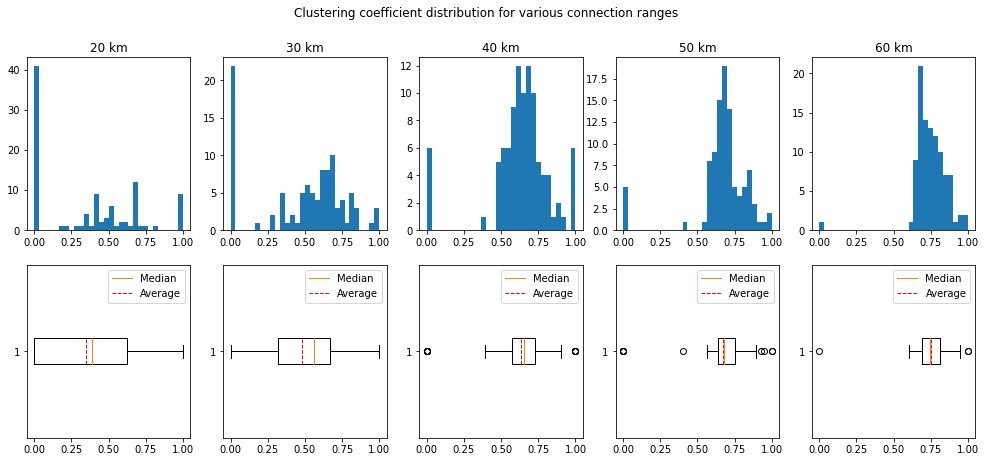

In [17]:
fig,ax = plt.subplots(nrows=2, ncols=5, figsize=(17,7))
fig.suptitle('Clustering coefficient distribution for various connection ranges')

ax[0][0].set_title('20 km')
ax[0][0].hist(cc20, bins=30, density=False)
bp = ax[1][0].boxplot(cc20, 
            vert=False, 
            meanline=True, 
            showmeans=True, 
            meanprops={'color':'red','ls':'--'}
            )
ax[1][0].legend([bp['medians'][0], bp['means'][0]], ['Median', 'Average'])

ax[0][1].set_title('30 km')
ax[0][1].hist(cc30, bins=30, density=False)
bp = ax[1][1].boxplot(cc30, 
            vert=False, 
            meanline=True, 
            showmeans=True, 
            meanprops={'color':'red','ls':'--'}
            )
ax[1][1].legend([bp['medians'][0], bp['means'][0]], ['Median', 'Average'])

ax[0][2].set_title('40 km')
ax[0][2].hist(cc40, bins=30, density=False)
bp = ax[1][2].boxplot(cc40, 
            vert=False, 
            meanline=True, 
            showmeans=True, 
            meanprops={'color':'red','ls':'--'}
            )
ax[1][2].legend([bp['medians'][0], bp['means'][0]], ['Median', 'Average'])

ax[0][3].set_title('50 km')
ax[0][3].hist(cc50, bins=30, density=False)
bp = ax[1][3].boxplot(cc50, 
            vert=False, 
            meanline=True, 
            showmeans=True, 
            meanprops={'color':'red','ls':'--'}
            )
ax[1][3].legend([bp['medians'][0], bp['means'][0]], ['Median', 'Average'])

ax[0][4].set_title('60 km')
ax[0][4].hist(cc60, bins=30, density=False)
bp = ax[1][4].boxplot(cc60, 
            vert=False, 
            meanline=True, 
            showmeans=True, 
            meanprops={'color':'red','ls':'--'}
            )
ax[1][4].legend([bp['medians'][0], bp['means'][0]], ['Median', 'Average'])

In [8]:
cc = swarm_20.connected_components()
print(cc)

Number of connected components: 26
[0, 19, 42, 9, 7, 17, 67, 55, 31, 58, 81, 64, 25, 94, 97, 5, 11, 24, 40, 27, 33, 22, 6, 18, 1, 15, 74, 30, 45, 8, 60, 72, 66, 65, 12, 32, 39, 56, 62, 76, 69, 68, 77, 23, 70, 50, 71, 78, 84, 90, 73, 57, 63, 75, 87, 21, 41, 95, 79]
[2]
[3]
[4]
[10, 49]
[13]
[14]
[16]
[20, 28, 29, 35, 44, 52, 48, 46, 59, 89, 80, 51, 96]
[26]
[34]
[36, 99]
[37]
[38]
[43]
[47]
[53]
[54]
[61]
[82, 91]
[83, 92]
[85]
[86]
[88]
[93]
[98]


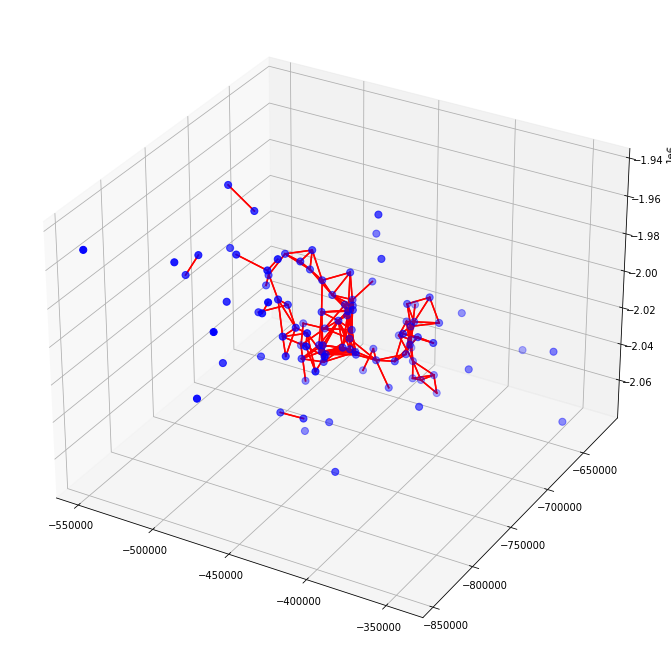

In [9]:
swarm_20.plot_edges()

In [4]:
cc = swarm_30.connected_components()
print(cc)

Number of connected components: 10
[[0, 19, 7, 9, 17, 5, 11, 24, 27, 1, 6, 15, 18, 22, 23, 21, 77, 12, 32, 65, 30, 8, 45, 39, 56, 62, 66, 60, 26, 76, 68, 72, 63, 4, 57, 33, 40, 41, 2, 44, 20, 28, 29, 35, 48, 46, 49, 10, 52, 51, 64, 13, 83, 89, 59, 91, 82, 88, 98, 92, 25, 81, 31, 55, 58, 80, 97, 42, 50, 70, 71, 78, 67, 14, 47, 73, 75, 87, 84, 90, 94, 79, 61, 38, 95, 96, 74, 69, 93, 43], [3], [16], [34], [36, 99], [37], [53], [54], [85], [86]]


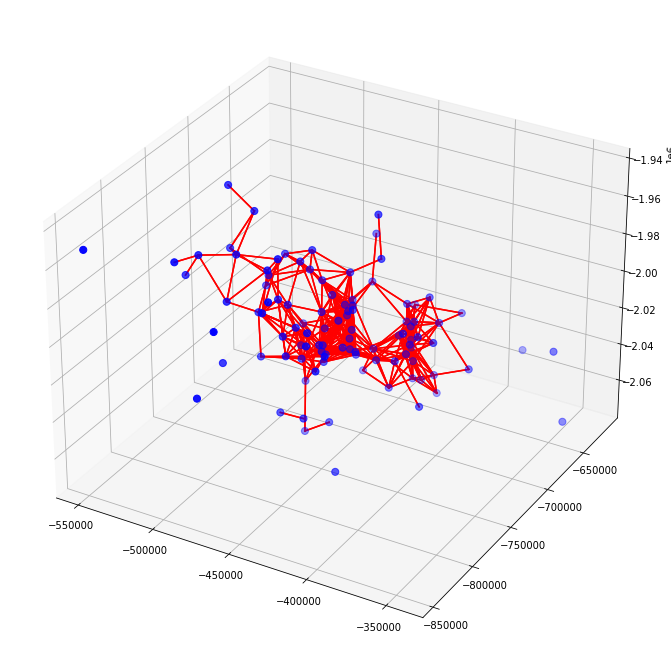

In [5]:
swarm_30.plot_edges()

In [11]:
cc = swarm_40.connected_components()
print(cc)

Number of connected components: 5
[0, 7, 5, 2, 11, 9, 1, 6, 8, 15, 18, 17, 14, 47, 67, 19, 21, 12, 32, 30, 22, 23, 27, 24, 33, 38, 36, 40, 41, 20, 28, 10, 29, 35, 16, 44, 48, 46, 49, 51, 13, 25, 31, 55, 42, 45, 26, 39, 56, 60, 62, 65, 66, 57, 4, 63, 68, 70, 50, 71, 52, 58, 59, 80, 64, 81, 83, 89, 82, 88, 91, 98, 92, 94, 73, 72, 74, 43, 90, 75, 77, 69, 76, 87, 93, 78, 84, 97, 95, 79, 61, 96, 99, 37]
[3, 86]
[34]
[53, 85]
[54]


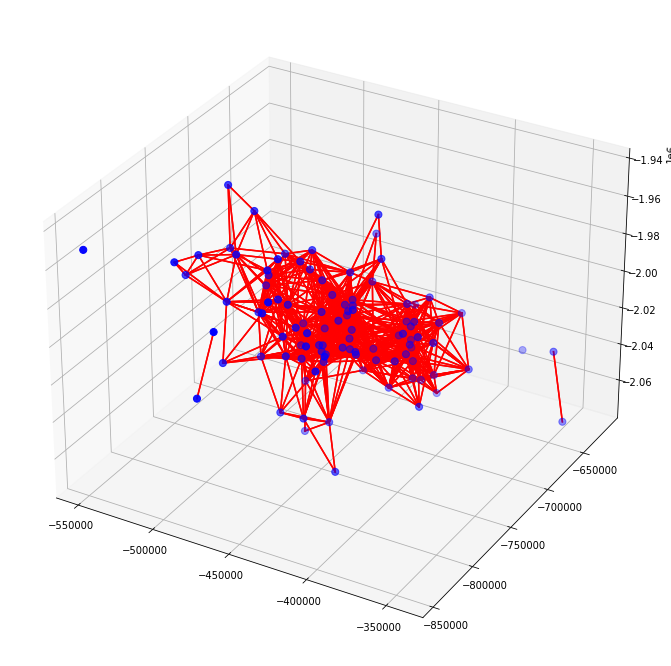

In [12]:
swarm_40.plot_edges()